# Section 4 - Autoencoders

### Autoencoder is a supervised machine learning model trying to predict itself.
With that process, encodings in the hidden layers create a different representation of the data.
Generally, the loss function of choice is the squared error function, however, other error function can be used as well, like cross-entropy assuming the output being either 0 or 1.
That is obtained by using the sigmoid function.

### Shared Weights
Share weights is a slight modification to normal approach where each layer has its own set of weights.
In this scenario, with one hidden layers, the network can be described by following equations:
\begin{equation*}
Z = s(X.dot(W) + b_{h})
\end{equation*}

\begin{equation*}
\check{X} = s(Z.dot(W^{T}) + b_{o} )
\end{equation*}

This technique can be considered a regularization technique, since it reduced number of parameters.

### Objective Function - Squared error
\begin{equation*}
J = |X - \check{X}|^2_{F} = |X - s(s(XW)W^{T})|^2_{F} 
\end{equation*}

That resembles PCA's objective function, which is given as:
\begin{equation*}
J = |X - XQQ^{T}|^2_{F} 
\end{equation*}

Because of that autoencoders are like nonlinear PCA.


## Tensorflow implementation

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

In [2]:
# Load the data
# The data is stored in folder for Section 2
# It will be re-used.
def getKaggleMNIST():
    # Column 0 is labels
    # Column 1-785 is data, with values 0 .. 255
    train = pd.read_csv('./data/Section 2/train.csv').as_matrix().astype(np.float32)
    train = shuffle(train)

    Xtrain = train[:-1000, 1:] / 255
    Ytrain = train[:-1000, 0].astype(np.int32)

    Xtest  = train[-1000:, 1:] / 255
    Ytest  = train[-1000:, 0].astype(np.int32)
    return Xtrain, Ytrain, Xtest, Ytest

Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()

In [3]:
Xtrain.shape

(41000, 784)

In [4]:
Xtest.shape

(1000, 784)

### Create network class

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
class AutoEncoder(object):
    def __init__(self, D, M, an_id):
        # Initialize the class
        self.M = M
        self.id = an_id
        self.build(D, M)

    def set_session(self, session):
        # Setting session
        self.session = session

    def build(self, D, M):
        # Build the network
        # Add variables and placeholders
        self.W = tf.Variable(tf.random_normal(shape = (D, M)))
        self.bh = tf.Variable(np.zeros(M).astype(np.float32))
        self.bo = tf.Variable(np.zeros(D).astype(np.float32))

        self.X_in = tf.placeholder(tf.float32, 
                                   shape = (None, D))
        self.Z = self.forward_hidden(self.X_in) 
        self.X_hat = self.forward_output(self.X_in)


        # Using the crossentropy 
        logits = self.forward_logits(self.X_in)
        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels = self.X_in,
                logits = logits,
            )
        )
        # Using Adam optimizer
        self.train_op = tf.train.AdamOptimizer(1e-1).minimize(self.cost)
        

    def fit(self, X, epochs = 1, batch_sz = 100, show_fig = False):
        N, D = X.shape
        
        # Setting number of batches as mod
        n_batches = N // batch_sz

        costs = []
        for i in range(epochs):
            print("Epoch:", i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j * batch_sz:(j * batch_sz + batch_sz)]
                _, c = self.session.run((self.train_op, self.cost), 
                                        feed_dict = {self.X_in: batch})
                if j % 100 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost:", c)
                costs.append(c)
        if show_fig:
            plt.figure(figsize = (12, 12))
            plt.title('Training loss')
            plt.plot(costs)
            plt.show()

    def transform(self, X):
        # accepts and returns a real numpy array
        # unlike forward_hidden and forward_output
        # which deal with tensorflow variables
        return self.session.run(self.Z, feed_dict={self.X_in: X})

    def predict(self, X):
        # accepts and returns a real numpy array
        # unlike forward_hidden and forward_output
        # which deal with tensorflow variables
        return self.session.run(self.X_hat, feed_dict={self.X_in: X})

    def forward_hidden(self, X):
        Z = tf.nn.sigmoid(tf.matmul(X, self.W) + self.bh)
        return Z

    def forward_logits(self, X):
        Z = self.forward_hidden(X)
        return tf.matmul(Z, tf.transpose(self.W)) + self.bo

    def forward_output(self, X):
        return tf.nn.sigmoid(self.forward_logits(X))

Epoch: 0
j / n_batches: 0 / 410 cost: 4.40132
j / n_batches: 100 / 410 cost: 0.15054007
j / n_batches: 200 / 410 cost: 0.13718803
j / n_batches: 300 / 410 cost: 0.12866303
j / n_batches: 400 / 410 cost: 0.12593128


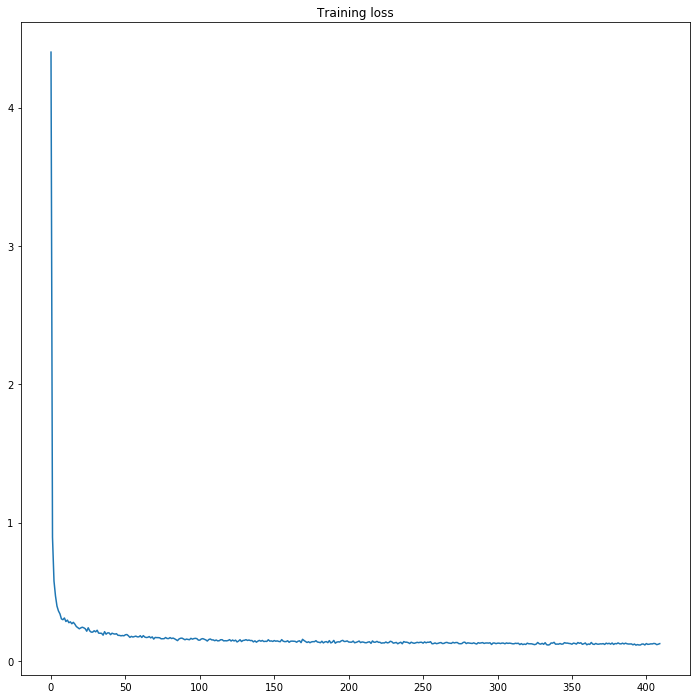

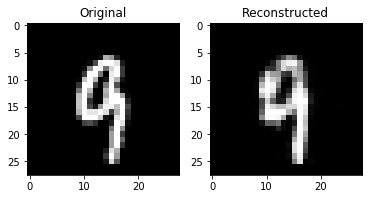

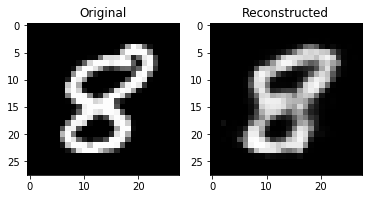

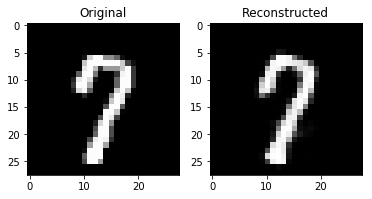

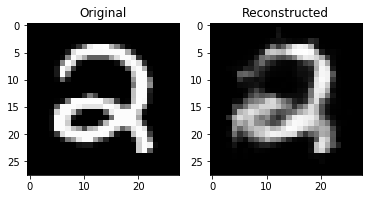

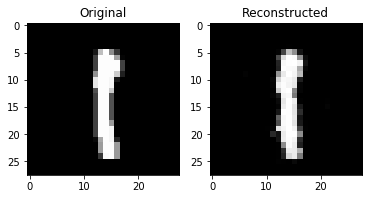

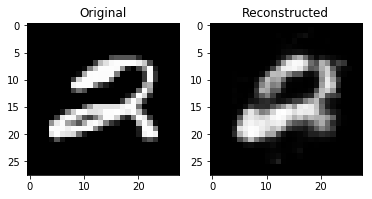

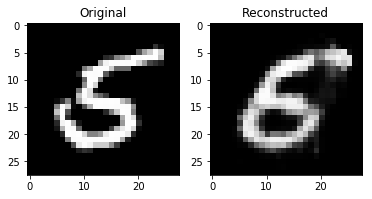

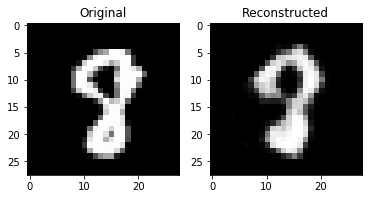

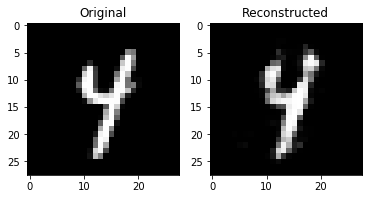

In [7]:
_, D = Xtrain.shape
autoencoder = AutoEncoder(D, 300, 0)
init_op = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init_op)
    autoencoder.set_session(session)
    autoencoder.fit(Xtrain, epochs = 1, show_fig = True)

    done = False
    while not done:
        i = np.random.choice(len(Xtest))
        x = Xtest[i]
        y = autoencoder.predict([x])
        plt.subplot(1, 2, 1)
        plt.imshow(x.reshape(28, 28), 
                   cmap = 'gray')
        plt.title('Original')

        plt.subplot(1,2,2)
        plt.imshow(y.reshape(28,28), 
                   cmap = 'gray')
        plt.title('Reconstructed')

        plt.show()

        ans = input("Generate another?: ")
        if ans and ans[0] in ('n' or 'N'):
            done = True